---

https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

http://adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

https://github.com/szagoruyko/pytorchviz

https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/

https://forums.fast.ai/t/pytorch-best-way-to-get-at-intermediate-layers-in-vgg-and-resnet/5707/2

https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/

https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader

In [10]:
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
x = Variable(torch.ones(2, 2) * 2, requires_grad=True)
z = 2 * (x * x) + 5 * x
z.backward(torch.ones(2, 2))
print(x.grad)

tensor([[13., 13.],
        [13., 13.]])


---

In [5]:
pretrained_model = models.vgg16(pretrained=True)
# resnet18 = models.resnet18(pretrained=True)

In [6]:
pretrained_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

---

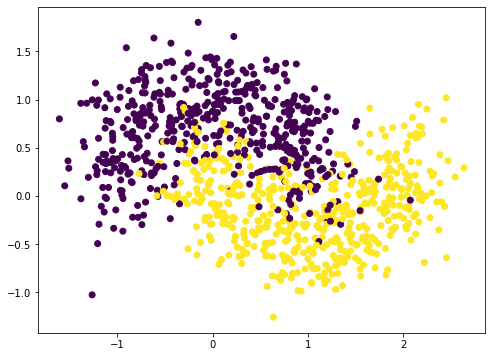

In [68]:
X, y = make_moons(n_samples=1000, noise=0.3)

plt.figure(figsize=(8,6))
plt.scatter(x=X[:,0], y=X[:,1], c=y)
plt.show()

In [69]:
y_softmax = np.zeros((len(y), 2))
for i in range(len(y)):
    y_softmax[i][y[i]] = 1

In [76]:
x_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y_softmax).float().to(device)

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, test_dataset = random_split(dataset, [500, 500])

train_loader = DataLoader(dataset=train_dataset, batch_size=50)
test_loader = DataLoader(dataset=test_dataset, batch_size=50)

In [77]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=0)

simple_net = SimpleNet()
print(simple_net)

SimpleNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
)


In [86]:
learning_rate = 0.01
n_epochs = 50

LossHistoryTrain = []
LossHistoryTest = []

correct = 0

# create a stochastic gradient descent optimizer
optimizer = optim.SGD(simple_net.parameters(), lr=learning_rate, momentum=0.9)
# create a loss function
criterion = nn.CrossEntropyLoss()

# run the main training loop
for epoch in range(1,n_epochs+1):
    
    simple_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        target_index = torch.max(target, 1)[1]
        
        net_out = simple_net(data)
        loss = criterion(net_out, target_index)
        
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        LossHistoryTrain.append(loss.item())
        
    simple_net.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = Variable(data), Variable(target)
        target_index = torch.max(target, 1)[1]
        
        net_out = simple_net(data)

        if epoch==n_epochs:
            pred = np.round(net_out.detach())
            target = np.round(target.detach())
            correct += pred.eq(target).sum().item()

        test_loss = criterion(net_out, target_index)
        LossHistoryTest.append(test_loss.item())

Accuracy: 500/500 (100%)



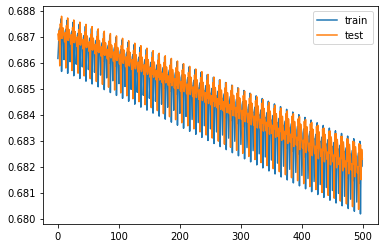

In [87]:
print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

plt.plot(LossHistoryTrain, label="train")
plt.plot(LossHistoryTest, label="test")
plt.legend()
plt.show()